In [1]:
#import libraries
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import scipy.integrate as integrate
import time


import constants as const
import coordinate_conversion as cc
import plot_settings

from matplotlib.ticker import FuncFormatter
formatter = FuncFormatter(lambda y, _: '{:.16g}'.format(y))

In [2]:
import matplotlib.font_manager
print(matplotlib.font_manager.findSystemFonts(fontpaths=None, fontext='ttf'))


['/System/Library/Fonts/Supplemental/Georgia Bold Italic.ttf', '/System/Library/Fonts/Supplemental/Gujarati Sangam MN.ttc', '/System/Library/Fonts/ヒラギノ角ゴシック W3.ttc', '/System/Library/Fonts/Supplemental/STIXIntUpDReg.otf', '/System/Library/Fonts/Keyboard.ttf', '/System/Library/Fonts/Supplemental/NotoSansKhudawadi-Regular.ttf', '/System/Library/Fonts/Supplemental/Arial Rounded Bold.ttf', '/System/Library/Fonts/Supplemental/Tamil MN.ttc', '/System/Library/Fonts/Supplemental/Papyrus.ttc', '/System/Library/Fonts/Supplemental/Bodoni 72 OS.ttc', '/System/Library/Fonts/Supplemental/NotoSansRejang-Regular.ttf', '/System/Library/Fonts/Supplemental/STIXSizThreeSymBol.otf', '/System/Library/Fonts/Supplemental/Arial Narrow.ttf', '/System/Library/Fonts/Supplemental/NotoSansChakma-Regular.ttf', '/System/Library/Fonts/Supplemental/Al Nile.ttc', '/System/Library/Fonts/Symbol.ttf', '/System/Library/Fonts/Supplemental/Sinhala MN.ttc', '/System/Library/Fonts/Supplemental/STIXIntUpSmReg.otf', '/System/Li

In [3]:
# Characteristic neutron star radius in [cm].
NS_radius = 1.1e6 #7.e8

# Characteristic neutron star mass in solar masses.
NS_mass = 1.4 * const.M_SUN

# Dimensionless coefficients k_0, k_1, k_2 for a force-free magnetosphere
# taken from Spitkovsky (2006) and Philippov et al. (2014).
# For comparison, in vacuum k_0 = 0 and k_1 = k_2 = 2/3.
k_coefficients = [1.0, 1.0, 1.0]

# Canonical neutron star moment of inertia in [g cm^2] assuming a perfect solid sphere.
NS_inertia = 2.0 / 5.0 * NS_mass * NS_radius ** 2

# Auxiliary quantity beta as defined in eq. (72) of Pons & Vigano (2019).
beta = 1./4. * NS_radius ** 6 / (NS_inertia * const.c ** 3)
#beta = np.pi ** 2 * NS_radius ** 6 / (NS_inertia * const.c ** 3)
print(beta)

# Assume an inclination angle in [rad].
chi = 0.

beta_1 = beta * (k_coefficients[0] + k_coefficients[1] * np.sin(chi) ** 2)
print(beta_1)

1.212915700688751e-41
1.212915700688751e-41


In [4]:
def period_derivative_B(P: float, B: float) -> float:
    """
    This function determines the change in the rotation period of a pulsar. It is taken
    from eq. (70) of Pons & Vigano (2019). For more details see, e.g., Spitkovsky (2006)
    or Philippov et al. (2014), who determine the coefficients k_0, k_1, k_2 (defined in
    the configuration file) for a pulsar embedded in a force-free and resistive magnetosphere
    from numerical simulations. Note that all three input parameters are time-dependent.

    Args:
        P (float): spin period of a simulated pulsar, measured in [s].
        B (float): value of the dipolar component of the magnetic field at the
        magnetic pole for a simulated neutron star, measured in [G].      

    Returns:
        (float): period derivative of a simulated pulsar in [s/s].
    """

    # Period derivative.
    P_deriv = 4 * np.pi**2 * beta_1 * B ** 2 / P

    return P_deriv

def period_derivative_tage(P: float, tage: float) -> float:
    """
    Pdot as a function of period with varying pulsar age assuming P >> P0 and constant magnetic field.
    
    Args:
        P (float): spin period of a simulated pulsar, measured in [s].
        tage (float): characteristic age in [yr].      

    Returns:
        (float): period derivative of a simulated pulsar in [s/s].
    """
    tage = tage * const.YR_TO_S
    
    P_deriv = P/(2.*tage)
    
    return P_deriv

def B_from_timing(P: float, Pdot: float) -> float:
    """
    B field estimated from timing properties. 
    Args:
        P (float): spin period of a simulated pulsar, measured in [s].
        Pdot (float): period derivative of a simulated pulsar in [s/s].   

    Returns:
        (float): value of the dipolar component of the magnetic field at the
        magnetic pole for a simulated neutron star, measured in [G].
    """

    # Period derivative.
    B = np.sqrt(P * Pdot / (4 * np.pi**2 * beta_1))

    return B

def tage_from_timing(P: float, Pdot: float) -> float:
    """
    Pulsar characteristic age from timing properties assuming P >> P0 and constant magnetic field. 
    
    Args:
        P (float): spin period of a simulated pulsar, measured in [s].
        Pdot (float): period derivative of a simulated pulsar in [s/s].   

    Returns:
        (float): characteristic age in [yr].     
    """

    # Period derivative.
    tage = P / (2 * Pdot) / const.YR_TO_S

    return tage

def Edot_from_timing(P: float, Pdot: float) -> float:
    """
    Pulsar rotational power from timing properties. 
    
    Args:
        P (float): spin period of a simulated pulsar, measured in [s].
        Pdot (float): period derivative of a simulated pulsar in [s/s].   

    Returns:
        (float): rotational power [erg/s].     
    """

    # Period derivative.
    Edot = 4 * np.pi**2 * NS_inertia * Pdot / P**3
    
    return Edot

In [5]:
df_atnf = pd.read_csv(
    "./atnf_all.csv",
    delimiter=";",
    header=[0, 1],
)
df_atnf.head()

,#,NAME,P0,P1,ASSOC,PSR,Unnamed: 6_level_0
,Unnamed: 0_level_1,Unnamed: 1_level_1,(s),(s/s),Type,TYPE,Unnamed: 6_level_1
0,1,J0002+6216,0.115364,5.97e-15,"GRS:4FGL_J0002.8+6217[aab+22],XRS:1XSPS_",HE[wcp+18],NaN
1,2,J0006+1834,0.693748,2.10e-15,NAN,NAN,NaN
2,3,J0007+7303,0.315873,3.60e-13,"GRS:4FGL_J0007.0+7303[aab+22],XRS:RX_J00",NRAD[aab+22],NaN
3,4,J0011+08,2.552870,NAN,NAN,NAN,NaN
4,5,J0012+5431,3.025301,1.28e-16,NAN,RRAT[cwp+17],NaN


In [6]:
df_atnf_binary = pd.read_csv(
    "./atnf_binary.csv",
    delimiter=";",
    header=[0, 1],
)
df_atnf_binary.head()

,#,NAME,P0,P1,ASSOC,PSR,Unnamed: 6_level_0
,Unnamed: 0_level_1,name,(s),(s/s),Type,TYPE,Unnamed: 6_level_1
0,1,J0023+0923,0.003050,1.14e-20,"GRS:4FGL_J0023.4+0920[aab+22],OPT:[bvr+1",HE,NaN
1,2,B0021-72E,0.003536,9.85e-20,"GC:47Tuc(NGC104),XRS:[bgh+06]",NAN,NaN
2,3,B0021-72H,0.003210,-1.83e-21,"GC:47Tuc(NGC104),XRS:[bgh+06]",NAN,NaN
3,4,B0021-72I,0.003485,-4.59e-20,"GC:47Tuc(NGC104),XRS:[bgh+06]",NAN,NaN
4,5,B0021-72J,0.002101,-9.79e-21,"GC:47Tuc(NGC104),XRS:[bgh+06]",NAN,NaN


In [7]:
# Read data from the Magnetar Outburst Online Catalog.
df_magnetar_McGill = pd.read_csv(
    "/Users/abubakribrahim/Desktop/observations/scripts/pdot_daigram/mcgil_name-p-pdot-assoc.csv", delimiter=";", header=[0, 1],
)
df_magnetar_McGill.head()

,#,NAME,P0,P1,ASSOC,Unnamed: 5_level_0
,Unnamed: 0_level_1,name,(s),(s/s),Type,Unnamed: 5_level_1
0,1,CXOU J010043.1-721134,8.020392,1.88e-11,SMC,
1,2,4U 0142+61,8.68869249,0.2022e-11,NaN,
2,3,SGR 0418+5729,9.07838822,0.0004e-11,NaN,
3,4,SGR 0501+4516,5.7620695,0.594e-11,SNR HB 9?,
4,5,SGR 0526-66,8.0544,3.8e-11,"LMC,SNR N49?, SL 463",


In [8]:
# Select only stars with measured P, Pdot, DM and radio flux.
# We also select only those that are not in globular clusters or in the Magellanic Clouds.
discard = [
    "EXGAL:SMC",
    "EXGAL:LMC",
    "GC:47Tuc",
    "GC:M3",
    "GC:M5",
    "GC:M13",
    "GC:NGC6440",
    "GC:Ter5",
    "GC:NGC6441",
    "GC:NGC6517",
    "GC:NGC6522",
    "GC:NGC6624",
    "GC:M28(NGC6626)",
    "GC:NGC6652",
    "GC:M22(NGC6656)",
    "GC:NGC6752",
    "GC:NGC6760",
    "GC:M15",
    "GC:M30",
]

df_atnf = df_atnf[~df_atnf["P0"]["(s)"].isin(['NAN'])]
df_atnf = df_atnf[~df_atnf["P1"]["(s/s)"].isin(['NAN'])]
#df_atnf = df_atnf[~df_atnf["ASSOC"]["Unnamed: 24_level_1"].str.contains('|'.join(discard))]
df_atnf_binary = df_atnf_binary[~df_atnf_binary["P0"]["(s)"].isin(['NAN'])]
df_atnf_binary = df_atnf_binary[~df_atnf_binary["P1"]["(s/s)"].isin(['NAN'])]
#df_atnf_binary = df_atnf_binary[~df_atnf_binary["ASSOC"]["Unnamed: 24_level_1"].str.contains('|'.join(discard))]

df_magnetar_McGill = df_magnetar_McGill[~df_magnetar_McGill["P0"]["(s)"].isin(['NAN'])]
df_magnetar_McGill = df_magnetar_McGill[~df_magnetar_McGill["P1"]["(s/s)"].isin(['NAN'])]


df_atnf_rrat = df_atnf[df_atnf['PSR']['TYPE'].str.contains("RRAT")]
df_atnf_axp = df_atnf[df_atnf['PSR']['TYPE'].str.contains("AXP")]
df_atnf_he = df_atnf[df_atnf['PSR']['TYPE'].str.contains("HE")]
df_atnf_nrad = df_atnf[df_atnf['PSR']['TYPE'].str.contains("NRAD")]
df_atnf_xins = df_atnf[df_atnf['PSR']['TYPE'].str.contains("XINS")]
df_atnf_snr = df_atnf[df_atnf['ASSOC']["Type"].str.contains(r'SNR')]
df_atnf_isolated = df_atnf[~df_atnf["ASSOC"]["Type"].str.contains('|'.join(discard))]

df_atnf_xins

#print(len(df_atnf_binary))
#print(len(df_magnetar_McGill))
print(df_magnetar_McGill)
print(df_atnf_xins)

                    #                   NAME            P0             P1  \
   Unnamed: 0_level_1                   name           (s)          (s/s)   
0                   1  CXOU J010043.1-721134      8.020392       1.88e-11   
1                   2             4U 0142+61    8.68869249     0.2022e-11   
2                   3          SGR 0418+5729    9.07838822     0.0004e-11   
3                   4          SGR 0501+4516     5.7620695      0.594e-11   
4                   5            SGR 0526-66        8.0544        3.8e-11   
5                   6         1E 1048.1-5937      6.457875       2.25e-11   
6                   7         1E 1547.0-5408     2.0721255       4.77e-11   
7                   8         PSR J1622-4950        4.3261        1.7e-11   
8                   9            SGR 1627-41      2.594578        1.9e-11   
9                  10  CXOU J164710.2-455216     10.610644       0.04e-11   
10                 11  1RXS J170849.0-400910   11.00502461     1.9455e-11   

/usr/local/anaconda3/lib/python3.8/site-packages/pandas/core/strings/accessor.py:101: UserWarning: This pattern has match groups. To actually get the groups, use str.extract.
  return func(self, *args, **kwargs)


In [9]:
P_min = 2.e-4
P_max = 300#1.e5
Pdot_min = 1.e-23
Pdot_max = 1.e-7 

log_P_edges = np.linspace(np.log10(P_min), np.log10(P_max), 51)
log_P_centers = 0.5 * (log_P_edges[1:] + log_P_edges[:-1])
P_edges = 10**log_P_edges
P_centers = 10**log_P_centers

log_Pdot_edges = np.linspace(np.log10(Pdot_min), np.log10(Pdot_max), 51)
log_Pdot_centers = 0.5 * (log_Pdot_edges[1:] + log_Pdot_edges[:-1])
Pdot_edges = 10**log_Pdot_edges
Pdot_centers = 10**log_Pdot_centers

P_grid, Pdot_grid = np.meshgrid(P_centers, Pdot_centers, indexing='ij')

B_timing = B_from_timing(P_grid, Pdot_grid)
tage_timing = tage_from_timing(P_grid, Pdot_grid)
Edot_timing = Edot_from_timing(P_grid, Pdot_grid)

349
32


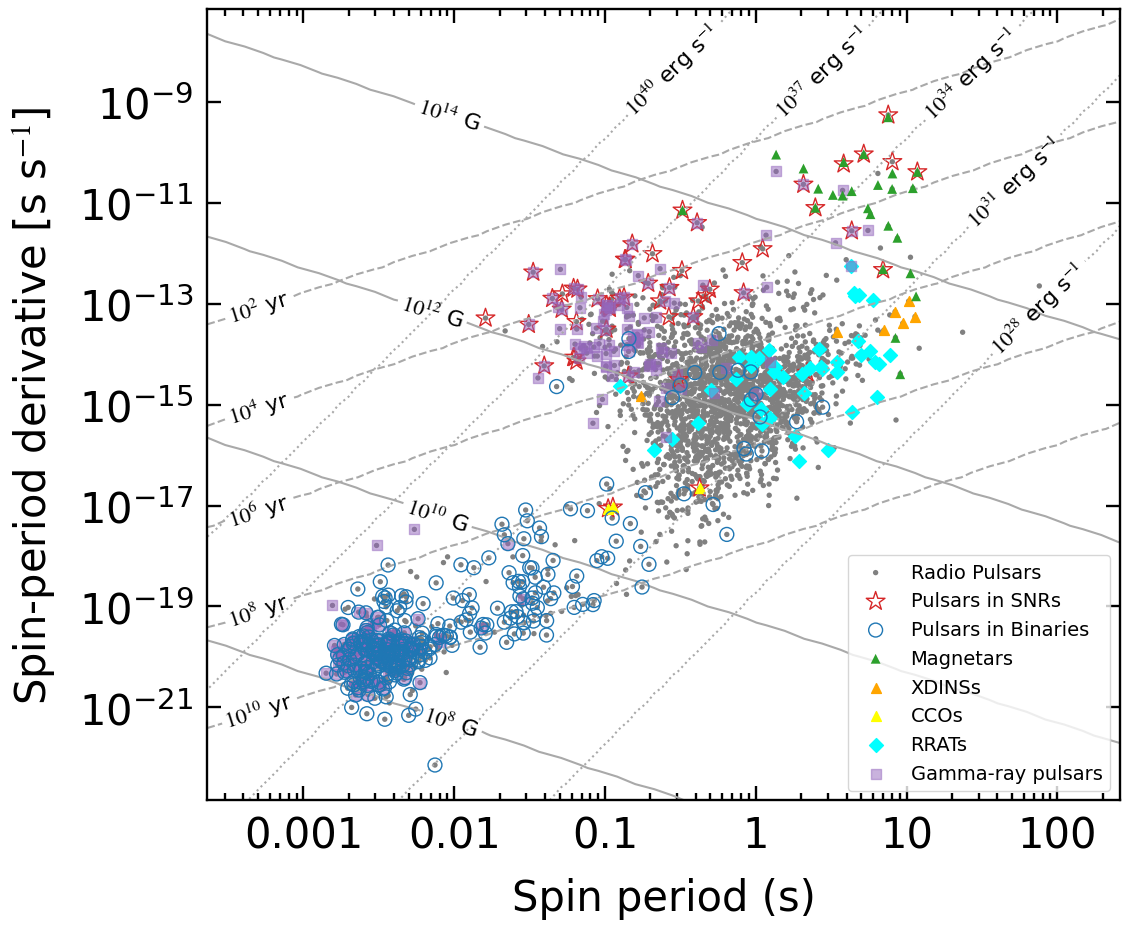

In [10]:
# plot the lines of constant magnetic field and age
fig, ax = plt.subplots(figsize=(12,10))

ax.set_xscale('log') 
ax.set_yscale('log')
#ax.set_xlim(P_min,P_max) 
#ax.set_ylim(Pdot_min,Pdot_max) 
ax.set_xlabel(r'Spin period (s)')
ax.set_ylabel(r'Spin-period derivative [s s$^{-1}$]')
ax.xaxis.set_major_formatter(formatter)

P = df_atnf["P0"]["(s)"].to_numpy().astype(float) 
Pdot = df_atnf["P1"]["(s/s)"].to_numpy().astype(float) 

ax.scatter(
    P,
    Pdot,
    linestyle="None",
    marker="o",
    facecolors='gray',
    edgecolors='None',
    s=15,
    alpha=1,
    rasterized=True,
    label=r'Radio Pulsars',
    zorder=2
)

P_snr = df_atnf_snr["P0"]["(s)"].to_numpy().astype(float) 
Pdot_snr = df_atnf_snr["P1"]["(s/s)"].to_numpy().astype(float) 

ax.scatter(
    P_snr,
    Pdot_snr,
    linestyle="None",
    marker="*",
    facecolors='None',
    edgecolors='tab:red',
    s=200,
    alpha=1,
    rasterized=True,
    label=r'Pulsars in SNRs',
    zorder=2
)

#for column in ["P0","P1"]:
#  df[column] = df[column].replace('*',np.nan)
#  df[column] = df[column].astype("float")
    
P_binary = df_atnf_binary["P0"]["(s)"].to_numpy().astype(float) 
Pdot_binary = df_atnf_binary["P1"]["(s/s)"].to_numpy().astype(float) 

print(len(P_binary))
print(len(P_binary[(P_binary>0.03) & (Pdot_binary>1.e-18)]))

ax.scatter(
    P_binary,
    Pdot_binary,
    linestyle="None",
    marker="o",
    facecolors='None',
    edgecolors='tab:blue',
    s=100,
    alpha=1,
    rasterized=True,
    label=r'Pulsars in Binaries',
    zorder=3
)

P_axp = df_magnetar_McGill["P0"]["(s)"].to_numpy().astype(float) 
Pdot_axp = df_magnetar_McGill["P1"]["(s/s)"].to_numpy().astype(float) 

ax.scatter(
    P_axp,
    Pdot_axp,
    linestyle="None",
    marker="^",
    facecolors='tab:green',
    edgecolors='None',
    s=50,
    alpha=1,
    rasterized=True,
    label=r'Magnetars',
    zorder=3
)

P_xins = df_atnf_xins["P0"]["(s)"].to_numpy().astype(float) 
Pdot_xins = df_atnf_xins["P1"]["(s/s)"].to_numpy().astype(float) 

ax.scatter(
    P_xins,
    Pdot_xins,
    linestyle="None",
    marker="^",
    facecolors='orange',
    edgecolors='orange',
    s=50,
    alpha=1,
    rasterized=True,
    label=r'XDINSs',
    zorder=2
)


#1E 1207.4–5209,PSR J1852+0040 (Kes 79),PSR J0821−4300
P_cco = np.array([0.424130748816, 0.104912611147, 0.112799455072]) 
Pdot_cco = np.array([2.224E-17, 8.68E-18, 9.3E-18]) 

ax.scatter(
    P_cco,
    Pdot_cco,
    linestyle="None",
    marker="^",
    facecolors='yellow',
    edgecolors='yellow',
    s=50,
    alpha=1,
    rasterized=True,
    label=r'CCOs',
    zorder=2
)

P_rrat = df_atnf_rrat["P0"]["(s)"].to_numpy().astype(float) 
Pdot_rrat = df_atnf_rrat["P1"]["(s/s)"].to_numpy().astype(float) 

ax.scatter(
    P_rrat,
    Pdot_rrat,
    linestyle="None",
    marker="D",
    facecolors='cyan',
    edgecolors='cyan',
    s=50,
    alpha=1,
    rasterized=True,
    label=r'RRATs',
    zorder=2
)


P_he = df_atnf_he["P0"]["(s)"].to_numpy().astype(float) 
Pdot_he = df_atnf_he["P1"]["(s/s)"].to_numpy().astype(float) 

ax.scatter(
    P_he,
    Pdot_he,
    linestyle="None",
    marker="s",
    facecolors='tab:purple',
    edgecolors='tab:purple',
    s=50,
    alpha=0.5,
    rasterized=True,
    label=r'Gamma-ray pulsars',
    zorder=2
)

'''
P_mag = df_magnetar["period(s)"].to_numpy().astype(float) 
Pdot_mag = df_magnetar["pdot(1e-11s/s)"].to_numpy().astype(float) * 10**(-11)

ax.scatter(
    P_mag,
    Pdot_mag,
    linestyle="None",
    marker="^",
    facecolors='tab:green',
    edgecolors='None',
    s=50,
    alpha=1,
    rasterized=True,
    label=r'Magnetar-like',
    zorder=3
)
'''
P_gleamx = 1091.17
Pdot_gleamx = 1.2e-9
'''
ax.errorbar(
    P_gleamx,
    Pdot_gleamx,
    yerr=1.e-9,
    uplims=1,
    #capsize=1.e-10,
    linestyle="None",
    marker="D",
    #facecolors='black',
    #edgecolors='black',
    color='black',
    markersize=7,
    alpha=1,
    rasterized=True,
    zorder=2
)
ax.text(P_gleamx/5, Pdot_gleamx*2, 'GLEAM-X J1627', fontsize = 15, rotation=0, color = 'black')
'''
P_mtp = 75.9
Pdot_mtp = 2.25e-13

ax.scatter(
    P_mtp,
    Pdot_mtp,
    linestyle="None",
    marker="o",
    facecolors='gray',
    edgecolors='None',
    s=15,
    alpha=1,
    rasterized=True,
    zorder=2,
    #label='PSR J0901-4046'
)
#ax.text(P_mtp/5, Pdot_mtp*2, ' PSR J0901-4046', fontsize = 15, rotation=0, color = 'black')
'''
P_1E = 6.67 * 3600.
Pdot_1E = 1.6e-9

ax.errorbar(
    P_1E,
    Pdot_1E,
    yerr=1.3e-9,
    uplims=1,
    #capsize=1.e-10,
    linestyle="None",
    marker="D",
    #facecolors='black',
    #edgecolors='black',
    color='black',
    markersize=7,
    alpha=1,
    rasterized=True,
    zorder=2
)
ax.text(P_1E/3, Pdot_1E*2, '1E 161348', fontsize = 15, rotation=0, color = 'black')
'''

contour_B = ax.contour(
    P_grid, 
    Pdot_grid,
    np.log10(B_timing), 
    levels = np.array([8.,10.,12.,14.]), 
    colors='darkgray',
    linestyles='solid'
    #interpolation='none'
)
fmt = {}
strs = ['$10^{8}$ G', '$10^{10}$ G', '$10^{12}$ G', '$10^{14}$ G']
for l,s in zip( contour_B.levels, strs ):
    fmt[l] = rf"{s}"
#manual_locations = [(5e-4, 1e-20), (1e-3, 1e-16), (2e-3, 1e-12), (0.01, 1e-9)]
# Adjust manual locations to be at the right side of the plot
manual_locations = [(100e-4, 1e-21), (1e-2, 1e-16), (1e-2, 1e-12), (0.01, 1e-9)]
ax.clabel(contour_B, contour_B.levels, inline=True, manual=manual_locations, fmt=fmt, fontsize=16, colors='black')



contour_Edot = ax.contour(
    P_grid, 
    Pdot_grid,
    np.log10(Edot_timing),
    levels = np.array([28.,31.,34.,37.,40.]), 
    colors='darkgray',
    linestyles='dotted'
    #interpolation='none'
)
fmt = {}
strs = ['$10^{28}$ erg s$^{-1}$', '$10^{31}$ erg s$^{-1}$', '$10^{34}$ erg s$^{-1}$', '$10^{37}$ erg s$^{-1}$', '$10^{40}$ erg s$^{-1}$']
for l,s in zip( contour_Edot.levels, strs ):
    fmt[l] = rf"{s}"
manual_locations = [(0.2, 1e-8), (2, 1e-8), (20, 1e-8), (70, 1e-11), (70, 1e-13)]
ax.clabel(
    contour_Edot, 
    contour_Edot.levels, 
    inline=True, 
    manual=manual_locations, 
    fmt=fmt, 
    fontsize=16, 
    colors='black'
    
)


contour_tage = ax.contour(
    P_grid, 
    Pdot_grid,
    np.log10(tage_timing),
    levels = np.array([2.,4.,6.,8.,10.]), 
    colors='darkgray',
    linestyles='dashed'
    #interpolation='none'
)
fmt = {}
strs = ['$10^{2}$ yr', '$10^{4}$ yr', '$10^{6}$ yr', '$10^{8}$ yr', '$10^{10}$ yr']
for l,s in zip( contour_tage.levels, strs ):
    fmt[l] = rf"{s}"
manual_locations = [(5e-4, 1e-13), (5e-4, 1e-15), (5e-4, 1e-17), (5e-4, 1e-19), (5e-4, 1e-21)]
ax.clabel(contour_tage, contour_tage.levels, inline=True, manual=manual_locations, fmt=fmt, fontsize=16, colors='black')




plt.legend(frameon=True,loc=4, prop={'size': 14})

fig.savefig("Ppdot_ATNFv2.2.0_McGill.pdf", bbox_inches="tight")
plt.show()

# This is the test to add the three magnetars labled

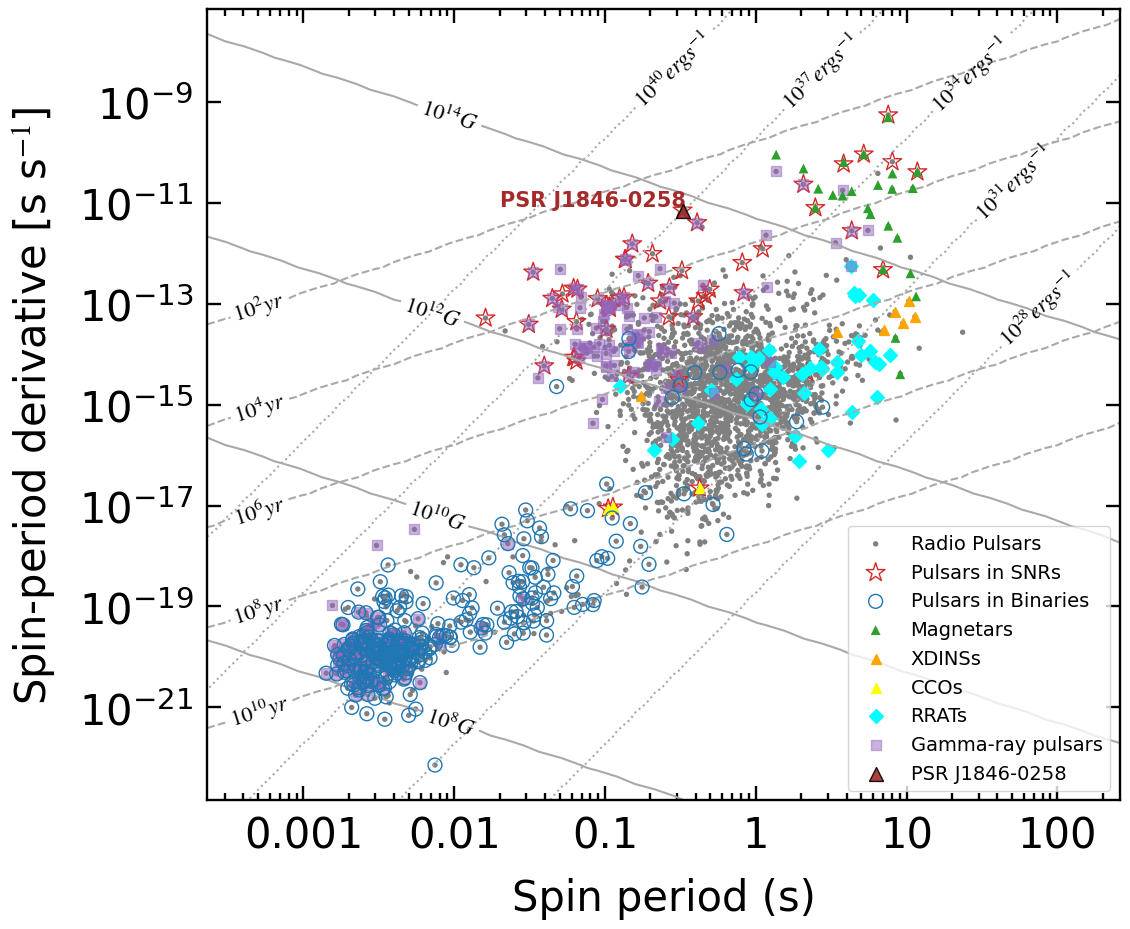

In [36]:
# plot the lines of constant magnetic field and age
fig, ax = plt.subplots(figsize=(12,10))

ax.set_xscale('log') 
ax.set_yscale('log')
ax.set_xlabel(r'Spin period (s)')
ax.set_ylabel(r'Spin-period derivative [s s$^{-1}$]')
ax.xaxis.set_major_formatter(formatter)

P = df_atnf["P0"]["(s)"].to_numpy().astype(float) 
Pdot = df_atnf["P1"]["(s/s)"].to_numpy().astype(float) 

ax.scatter(
    P,
    Pdot,
    linestyle="None",
    marker="o",
    facecolors='gray',
    edgecolors='None',
    s=15,
    alpha=1,
    rasterized=True,
    label=r'Radio Pulsars',
    zorder=2
)

P_snr = df_atnf_snr["P0"]["(s)"].to_numpy().astype(float) 
Pdot_snr = df_atnf_snr["P1"]["(s/s)"].to_numpy().astype(float) 

ax.scatter(
    P_snr,
    Pdot_snr,
    linestyle="None",
    marker="*",
    facecolors='None',
    edgecolors='tab:red',
    s=200,
    alpha=1,
    rasterized=True,
    label=r'Pulsars in SNRs',
    zorder=2
)

P_binary = df_atnf_binary["P0"]["(s)"].to_numpy().astype(float) 
Pdot_binary = df_atnf_binary["P1"]["(s/s)"].to_numpy().astype(float) 

ax.scatter(
    P_binary,
    Pdot_binary,
    linestyle="None",
    marker="o",
    facecolors='None',
    edgecolors='tab:blue',
    s=100,
    alpha=1,
    rasterized=True,
    label=r'Pulsars in Binaries',
    zorder=3
)

P_axp = df_magnetar_McGill["P0"]["(s)"].to_numpy().astype(float) 
Pdot_axp = df_magnetar_McGill["P1"]["(s/s)"].to_numpy().astype(float) 

ax.scatter(
    P_axp,
    Pdot_axp,
    linestyle="None",
    marker="^",
    facecolors='tab:green',
    edgecolors='None',
    s=50,
    alpha=1,
    rasterized=True,
    label=r'Magnetars',
    zorder=3
)

P_xins = df_atnf_xins["P0"]["(s)"].to_numpy().astype(float) 
Pdot_xins = df_atnf_xins["P1"]["(s/s)"].to_numpy().astype(float) 

ax.scatter(
    P_xins,
    Pdot_xins,
    linestyle="None",
    marker="^",
    facecolors='orange',
    edgecolors='orange',
    s=50,
    alpha=1,
    rasterized=True,
    label=r'XDINSs',
    zorder=2
)

# CCOs
P_cco = np.array([0.424130748816, 0.104912611147, 0.112799455072]) 
Pdot_cco = np.array([2.224E-17, 8.68E-18, 9.3E-18]) 

ax.scatter(
    P_cco,
    Pdot_cco,
    linestyle="None",
    marker="^",
    facecolors='yellow',
    edgecolors='yellow',
    s=50,
    alpha=1,
    rasterized=True,
    label=r'CCOs',
    zorder=2
)

P_rrat = df_atnf_rrat["P0"]["(s)"].to_numpy().astype(float) 
Pdot_rrat = df_atnf_rrat["P1"]["(s/s)"].to_numpy().astype(float) 

ax.scatter(
    P_rrat,
    Pdot_rrat,
    linestyle="None",
    marker="D",
    facecolors='cyan',
    edgecolors='cyan',
    s=50,
    alpha=1,
    rasterized=True,
    label=r'RRATs',
    zorder=2
)

P_he = df_atnf_he["P0"]["(s)"].to_numpy().astype(float) 
Pdot_he = df_atnf_he["P1"]["(s/s)"].to_numpy().astype(float) 

ax.scatter(
    P_he,
    Pdot_he,
    linestyle="None",
    marker="s",
    facecolors='tab:purple',
    edgecolors='tab:purple',
    s=50,
    alpha=0.5,
    rasterized=True,
    label=r'Gamma-ray pulsars',
    zorder=2
)

# Plot special sources
magnetar_labels = {
    "PSR J1846-0258": {"color": "brown", "P": 0.327, "Pdot": 0.7e-11}
}
# "Swift J1818.0-1607": {"color": "red", "P": 1.36, "Pdot": 9e-11}
# "SGR 1935+2154": {"color": "purple", "P": 3.24, "Pdot": 1.43e-11}
# "PSR J1846-0258": {"color": "brown", "P": 0.327, "Pdot": 0.7e-11}
        
for name, properties in magnetar_labels.items():
    ax.scatter(
        properties["P"],
        properties["Pdot"],
        linestyle="None",
        marker="^",
        facecolors=properties["color"],
        edgecolors='black',
        s=100,
        alpha=0.9,
        rasterized=True,
        zorder=4,
        label=name
    )
    ax.text(
        properties["P"] * 1.05,
        properties["Pdot"] * 1.05, 
        name, 
        fontsize=15, 
        color=properties["color"],
        weight='bold',
        ha='right',
        va='bottom',
        ma='center'
    )

# Contour lines
contour_B = ax.contour(
    P_grid, 
    Pdot_grid,
    np.log10(B_timing), 
    levels=np.array([8.,10.,12.,14.]), 
    colors='darkgray',
    linestyles='solid'
)
fmt = {l: f"${s}$" for l, s in zip(contour_B.levels, ['10^{8} G', '10^{10} G', '10^{12} G', '10^{14} G'])}
manual_locations = [(100e-4, 1e-21), (1e-2, 1e-16), (1e-2, 1e-12), (0.01, 1e-9)]
ax.clabel(contour_B, contour_B.levels, inline=True, manual=manual_locations, fmt=fmt, fontsize=16, colors='black')

contour_Edot = ax.contour(
    P_grid, 
    Pdot_grid,
    np.log10(Edot_timing),
    levels=np.array([28.,31.,34.,37.,40.]), 
    colors='darkgray',
    linestyles='dotted'
)
fmt = {l: f"${s}$" for l, s in zip(contour_Edot.levels, ['10^{28} erg s^{-1}', '10^{31} erg s^{-1}', '10^{34} erg s^{-1}', '10^{37} erg s^{-1}', '10^{40} erg s^{-1}'])}
manual_locations = [(0.2, 1e-8), (2, 1e-8), (20, 1e-8), (70, 1e-11), (70, 1e-13)]
ax.clabel(contour_Edot, contour_Edot.levels, inline=True, manual=manual_locations, fmt=fmt, fontsize=16, colors='black')

contour_tage = ax.contour(
    P_grid, 
    Pdot_grid,
    np.log10(tage_timing),
    levels=np.array([2.,4.,6.,8.,10.]), 
    colors='darkgray',
    linestyles='dashed'
)
fmt = {l: f"${s}$" for l, s in zip(contour_tage.levels, ['10^{2} yr', '10^{4} yr', '10^{6} yr', '10^{8} yr', '10^{10} yr'])}
manual_locations = [(5e-4, 1e-13), (5e-4, 1e-15), (5e-4, 1e-17), (5e-4, 1e-19), (5e-4, 1e-21)]
ax.clabel(contour_tage, contour_tage.levels, inline=True, manual=manual_locations, fmt=fmt, fontsize=16, colors='black')

# Legend
handles, labels = ax.get_legend_handles_labels()
unique_labels = dict(zip(labels, handles))
ax.legend(unique_labels.values(), unique_labels.keys(), frameon=True, loc=4, prop={'size': 14})

# Save the figure
fig.savefig("Ppdot_ATNFv2.2.0_McGill_PSRJ1846.pdf", bbox_inches="tight")

# Show the plot
plt.show()


In [12]:
ra_gleam = np.array([246.9979])
dec_gleam = np.array([-52.5845])
d_gleam = np.array([1.3])
l_gleam, b_gleam, d_gleam, _, _, _ = cc.icrs_to_galactic(ra_gleam, dec_gleam, d_gleam)
x_gleam, y_gleam, z_gleam, _, _, _ = cc.galactic_to_galactocentric(l_gleam, b_gleam, d_gleam)

print(l_gleam)
print(b_gleam)

v_gleam = z_gleam * const.KPC_TO_KM / (1.e5 * const.YR_TO_S)

print(v_gleam)
print(cc.icrs_to_galactic(274.50080583, -16.13139025, d_gleam))

ra_mtp = np.array([135.371870833])
dec_mtp = np.array([-40.767495556])
d_mtp = np.array([350])
l_mtp, b_mtp, d_mtp, _, _, _ = cc.icrs_to_galactic(ra_mtp, dec_mtp, d_mtp)

print(l_mtp)
print(b_mtp)

[-27.53536354]
[-2.60092472]
[-408.671643]
(array([14.81529598]), array([-0.13796241]), array([1.3]), None, None, None)
[-96.86002499]
[3.70012329]


fig, ax = plt.subplots(figsize=(15, 8))

l = df_atnf["Gl"]["[deg]"].to_numpy().astype(float) 
b = df_atnf["Gb"]["[deg]"].to_numpy().astype(float)
l[(l > 180.0) & (l < 360.0)] = l[(l > 180.0) & (l < 360.0)] - 360.0

ax.scatter(
    l,
    b,
    linestyle="None",
    marker="o",
    facecolors='tab:red',
    edgecolors='None',
    s=15,
    alpha=1,
    rasterized=True,
    label=r'Radio Pulsars',
    zorder=2
)

l_snr = df_atnf_snr["Gl"]["[deg]"].to_numpy().astype(float) 
b_snr = df_atnf_snr["Gb"]["[deg]"].to_numpy().astype(float) 
l_snr[(l_snr > 180.0) & (l_snr < 360.0)] = l_snr[(l_snr > 180.0) & (l_snr < 360.0)] - 360.0

ax.scatter(
    l_snr,
    b_snr,
    linestyle="None",
    marker="*",
    facecolors='None',
    edgecolors='black',
    s=200,
    alpha=1,
    rasterized=True,
    label=r'Pulsars in SNR',
    zorder=2
)

l_binary = df_atnf_binary["Gl"]["[deg]"].to_numpy().astype(float) 
b_binary = df_atnf_binary["Gb"]["[deg]"].to_numpy().astype(float) 
l_binary[(l_binary > 180.0) & (l_binary < 360.0)] = l_binary[(l_binary > 180.0) & (l_binary < 360.0)] - 360.0

ax.scatter(
    l_binary,
    b_binary,
    linestyle="None",
    marker="o",
    facecolors='None',
    edgecolors='tab:blue',
    s=100,
    alpha=1,
    rasterized=True,
    label=r'Pulsars in Binaries',
    zorder=3
)

l_axp = df_atnf_axp["Gl"]["[deg]"].to_numpy().astype(float) 
b_axp = df_atnf_axp["Gb"]["[deg]"].to_numpy().astype(float) 
l_axp[(l_axp > 180.0) & (l_axp < 360.0)] = l_axp[(l_axp > 180.0) & (l_axp < 360.0)] - 360.0

ax.scatter(
    l_axp,
    b_axp,
    linestyle="None",
    marker="^",
    facecolors='tab:green',
    edgecolors='None',
    s=50,
    alpha=1,
    rasterized=True,
    label=r'Magnetar-like',
    zorder=3
)

l_xins = df_atnf_xins["Gl"]["[deg]"].to_numpy().astype(float) 
b_xins = df_atnf_xins["Gb"]["[deg]"].to_numpy().astype(float) 
l_xins[(l_xins > 180.0) & (l_xins < 360.0)] = l_xins[(l_xins > 180.0) & (l_xins < 360.0)] - 360.0

ax.scatter(
    l_xins,
    b_xins,
    linestyle="None",
    marker="^",
    facecolors='tab:orange',
    edgecolors='tab:orange',
    s=50,
    alpha=1,
    rasterized=True,
    label=r'XDINs',
    zorder=2
)

l_rrat = df_atnf_rrat["Gl"]["[deg]"].to_numpy().astype(float) 
b_rrat = df_atnf_rrat["Gb"]["[deg]"].to_numpy().astype(float) 
l_rrat[(l_rrat > 180.0) & (l_rrat < 360.0)] = l_rrat[(l_rrat > 180.0) & (l_rrat < 360.0)] - 360.0

ax.scatter(
    l_rrat,
    b_rrat,
    linestyle="None",
    marker="^",
    facecolors='cyan',
    edgecolors='cyan',
    s=50,
    alpha=1,
    rasterized=True,
    label=r'RRATs',
    zorder=2
)


l_he = df_atnf_he["Gl"]["[deg]"].to_numpy().astype(float) 
b_he = df_atnf_he["Gb"]["[deg]"].to_numpy().astype(float) 
l_he[(l_he > 180.0) & (l_he < 360.0)] = l_he[(l_he > 180.0) & (l_he < 360.0)] - 360.0

ax.scatter(
    l_he,
    b_he,
    linestyle="None",
    marker="s",
    facecolors='tab:purple',
    edgecolors='tab:purple',
    s=50,
    alpha=0.5,
    rasterized=True,
    label=r'High-energy pulsars',
    zorder=2
)

ax.scatter(
    l_mtp,
    b_mtp,
    linestyle="None",
    marker="D",
    facecolors='black',
    edgecolors='black',
    s=50,
    alpha=1,
    rasterized=True,
    zorder=2,
    label='PSR J0901-4046'
)

ax.plot(0.0, 0.0, marker="x", color="black", markersize=10)
ax.set_xlim(-180.0, 180.0)
#ax.set_ylim(-10.0, 10.0)
ax.set_xlabel("l [deg]")
ax.set_ylabel("b [deg]")
plt.legend(frameon=True,loc=4, prop={'size': 14})
'''
scatter = ax.scatter(
    l_axp,
    b_axp,
    linestyle="None",
    marker="^",
    c=dist_axp,
    cmap = "viridis",
    s=80,
    alpha=1.,
    rasterized=True,
)
cbar = fig.colorbar(scatter, ax = ax)
cbar.set_label(r'distance [kpc]')
'''
#fig.savefig("gleam_gal_pos.pdf", bbox_inches="tight")
plt.show()

# plot the lines of constant magnetic field and age
fig, ax = plt.subplots(figsize=(12,10))

ax.set_xscale('log') 
ax.set_yscale('log')
ax.set_xlim(P_min,P_max) 
ax.set_ylim(Pdot_min,Pdot_max) 
ax.set_xlabel(r'Spin period (s)')
ax.set_ylabel(r'Spin period derivative')
ax.xaxis.set_major_formatter(formatter)

P_iso = df_atnf_isolated["P0"]["(s)"].to_numpy().astype(float) 
Pdot_iso = df_atnf_isolated["P1"]["(s/s)"].to_numpy().astype(float) 

cond = (Pdot_iso > 1.e-18) & (Pdot_iso < 1.e-10) & (P_iso > 0.02 )

P_iso = P_iso[cond]
Pdot_iso = Pdot_iso[cond]

ax.scatter(
    P_iso,
    Pdot_iso,
    linestyle="None",
    marker="o",
    facecolors='black',
    edgecolors='None',
    s=15,
    alpha=1,
    rasterized=True,
    label=r'Isolated Radio Pulsars',
    zorder=2
)

P_mtp = 75.9
Pdot_mtp = 2.25e-13

ax.scatter(
    P_mtp,
    Pdot_mtp,
    linestyle="None",
    marker="D",
    facecolors='black',
    edgecolors='black',
    s=50,
    alpha=1,
    rasterized=True,
    zorder=2,
    label='PSR J0901-4046'
)

contour_B = ax.contour(
    P_grid, 
    Pdot_grid,
    np.log10(B_timing), 
    levels = np.array([8.,10.,12.,14.,16.]), 
    colors='gray',
    linestyles='solid'
    #interpolation='none'
)
fmt = {}
strs = ['$10^{8}$ G', '$10^{10}$ G', '$10^{12}$ G', '$10^{14}$ G', '$10^{16}$ G']
for l,s in zip( contour_B.levels, strs ):
    fmt[l] = rf"{s}"
manual_locations = [(5e-2, 1e-22), (3, 1e-19), (30, 1e-17), (100, 1e-13), (100, 1e-9)]
ax.clabel(contour_B, contour_B.levels, inline=True, manual=manual_locations, fmt=fmt, fontsize=20, colors='black')

contour_tage = ax.contour(
    P_grid, 
    Pdot_grid,
    np.log10(tage_timing),
    levels = np.array([2.,4.,6.,8.,10.]), 
    colors='gray',
    linestyles='dashed'
    #interpolation='none'
)
fmt = {}
strs = ['$10^{2}$ yr', '$10^{4}$ yr', '$10^{6}$ yr', '$10^{8}$ yr', '$10^{10}$ yr']
for l,s in zip( contour_tage.levels, strs ):
    fmt[l] = rf"{s}"
manual_locations = [(5e-4, 1e-13), (5e-4, 1e-15), (5e-4, 1e-17), (5e-4, 1e-19), (5e-4, 1e-21)]
ax.clabel(contour_tage, contour_tage.levels, inline=True, manual=manual_locations, fmt=fmt, fontsize=20, colors='black')

plt.legend(frameon=True,loc=4, prop={'size': 14})

fig.savefig("P-Pdot_isolated.pdf", bbox_inches="tight")
plt.show()

ra_axp = df_atnf_axp["RAJD"]["[deg]"].to_numpy().astype(float) 
dec_axp = df_atnf_axp["DECJD"]["[deg]"].to_numpy().astype(float) 
dist_axp = df_atnf_axp["DIST"]["[kpc]"].to_numpy().astype(float) 
l_axp = df_atnf_axp["Gl"]["[deg]"].to_numpy().astype(float) 
b_axp = df_atnf_axp["Gb"]["[deg]"].to_numpy().astype(float) 
l_axp[l_axp > 180.] = l_axp[l_axp > 180.] - 360.

print(df_atnf_axp["PSRJ"]["Unnamed: 1_level_1"])
print(l_axp)
print(b_axp)
print(P_axp/(2*Pdot_axp) / const.YR_TO_S)

RA_galcen = 266.4
DEC_galcen = -29.0

fig, ax = plt.subplots(figsize=(15, 8))

ax.plot(
    ra_axp,
    dec_axp,
    linestyle="None",
    marker="^",
    color="tab:green",
    markersize=10,
    alpha=1,
    rasterized=True,
    label=r"Magnetar-like",
)
ax.plot(
    ra_gleam,
    dec_gleam,
    linestyle="None",
    marker="*",
    color="tab:red",
    markersize=20,
    alpha=1,
    rasterized=True,
    label=r"GLEAM-X",
)

ax.plot(RA_galcen, DEC_galcen, marker="x", color="black", markersize=20)
ax.set_xlim(0.0, 360.0)
ax.set_ylim(-90.0, 90.0)
ax.set_xlabel("RA [deg]")
ax.set_ylabel("DEC [deg]")
ax.legend(frameon=True, loc=0)

plt.show()

NameError: name 'l_axp' is not defined

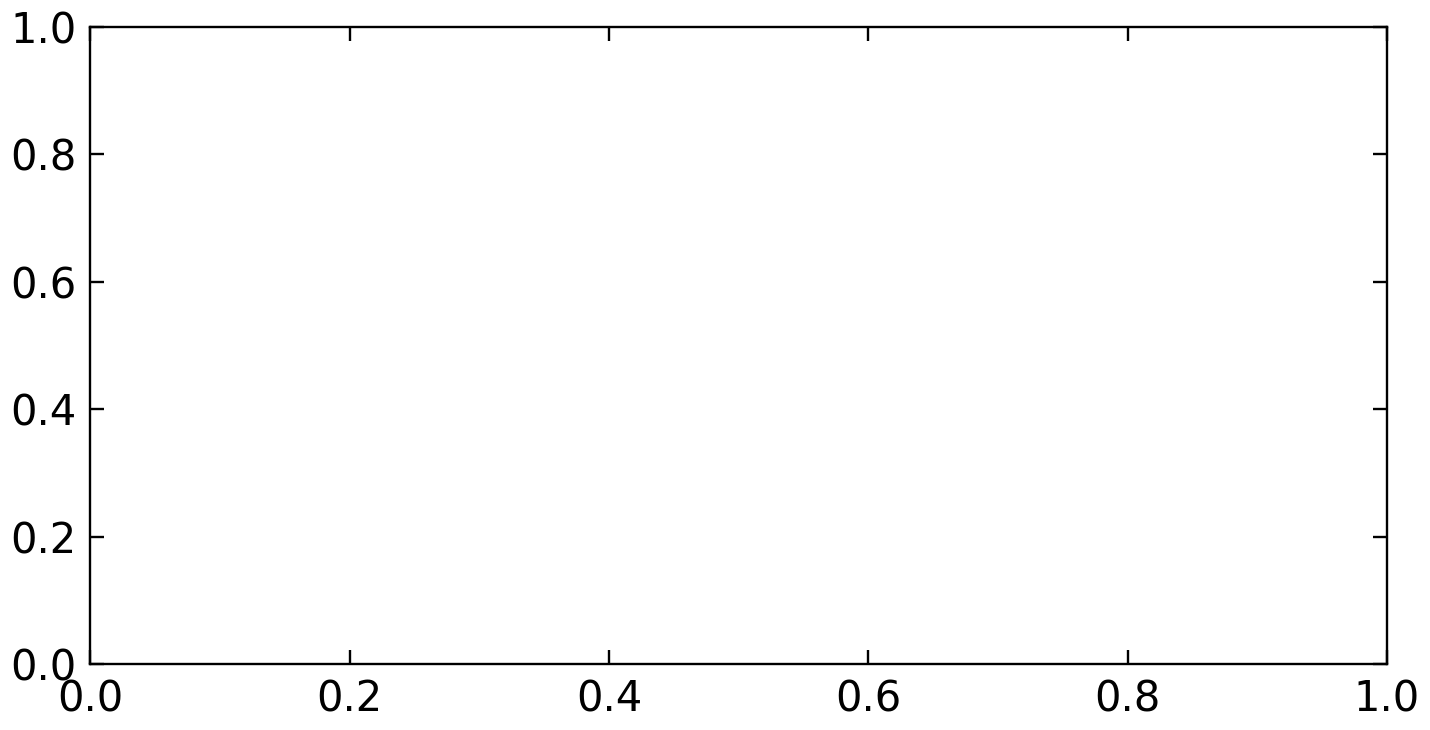

In [13]:
fig, ax = plt.subplots(figsize=(15, 8))

ax.plot(
    #l_axp[abs(b_axp) < 10],
    #b_axp[abs(b_axp) < 10],
    l_axp,
    b_axp,
    linestyle="None",
    marker="^",
    color="tab:green",
    markersize=10,
    alpha=1,
    rasterized=True,
    label=r"Magnetar-like",
)

ax.plot(l_gleam, b_gleam, marker="*", linestyle="None", color="tab:red", markersize=20, label=r"GLEAM-X")

ax.plot(0.0, 0.0, marker="x", color="black", markersize=10)
ax.set_xlim(-180.0, 180.0)
#ax.set_ylim(-10.0, 10.0)
ax.set_xlabel("l [deg]")
ax.set_ylabel("b [deg]")
ax.legend(frameon=True, loc=0)
'''
scatter = ax.scatter(
    l_axp,
    b_axp,
    linestyle="None",
    marker="^",
    c=dist_axp,
    cmap = "viridis",
    s=80,
    alpha=1.,
    rasterized=True,
)
cbar = fig.colorbar(scatter, ax = ax)
cbar.set_label(r'distance [kpc]')
'''
#fig.savefig("gleam_gal_pos.pdf", bbox_inches="tight")
plt.show()

t_c = P/(2*Pdot) / const.YR_TO_S
t_c_snr = P_snr/(2*Pdot_snr) / const.YR_TO_S

In [ ]:
t_c_bins = np.logspace(1, 12, 31)

fig, ax = plt.subplots(figsize=(15, 8))

ax.hist(
    t_c,
    bins=t_c_bins,
    histtype="stepfilled",
    color="darkgray",
    lw=4,
    label="All",
)
ax.hist(
    t_c_snr,
    bins=t_c_bins,
    histtype="step",
    edgecolor="tab:red",
    lw=4,
    label="SNR association",
)
plt.xlabel(r"$\tau_{\rm c}$ [yr]")
plt.ylabel(r"Number of NSs")
ax.set_xscale("log")
ax.set_yscale("log")
ax.legend(frameon=False, loc=0)

fig.savefig("snr_association_histo.pdf", bbox_inches="tight")
plt.show()

In [ ]:
Edot = Edot_from_timing(P, Pdot)
B = B_from_timing(P, Pdot)

In [ ]:
fig, ax = plt.subplots(figsize=(15, 8))

ax.loglog(
    t_c,
    B,
    "o",
    color="tab:red",
    ms=6,
    alpha=0.2,
    rasterized=True,
    label="Observed PMPS",
)

#plt.xlim(3.0e-2, 20)
#plt.ylim(1, 400)
plt.xlabel(r"$\tau$ [s]")
plt.ylabel(r"$B$ [G]")
ax.legend(frameon=True, loc=3)

plt.show()

In [ ]:
fig, ax = plt.subplots(figsize=(15, 8))

ax.loglog(
    B,
    Edot,
    "o",
    color="tab:red",
    ms=6,
    alpha=0.2,
    rasterized=True,
    label="Observed PMPS",
)

#plt.xlim(3.0e-2, 20)
#plt.ylim(1, 400)
plt.xlabel(r"$B$ [G]")
plt.ylabel(r"$\dot{E}$ [erg/s]")
ax.legend(frameon=True, loc=3)

plt.show()